In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

코랩 사용하시는 분들은 아래의 코드를 실행해주세요!

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# import os
# os.getcwd()

코랩 사용시 본인 구글 드라이브 경로는  
/content/drive/MyDrive/...  
입니다.

In [4]:
# path = './drive/MyDrive/...'    # 과제 데이터셋이 저장된 경로를 더 작성해주세요
# os.chdir(path)

In [5]:
# os.getcwd()

사용할 데이터 셋 :  전력 사용량 예측 모델

아래의 과정에서 sklearn의 Pipeline의 사용은 필수는 아닙니다. 선호와 필요에 따라 사용하실 분들은 사용하셔도 좋습니다.

# 데이터

건물 정보와 기후 정보를 활용한 전력사용량 예측 데이터 중에서 

환경 변수(기온, 풍속, 습도, 강수량, 일조)에 대해 전력 사용량을 선형회귀 모델을 사용해서 예측해보고자 합니다.

In [316]:
var_name = ['Temp', 'Wind', 'Moisture', 'Precipitation', 'Sun']
target = 'Wh'

In [317]:
def parsing(data: pd.DataFrame):
    x = data.iloc[:, 3:8]
    x.columns = var_name
    y = data.iloc[:, 2]
    y.name = target
    
    return x, y

In [318]:
def load_data():
    data = pd.read_csv('data/train.csv', encoding='cp949')
    data = data[: 100]
    x, y = parsing(data)    
    cut = int(round(len(x)*0.88))
    tr_x = x[:cut]
    tr_y = y[:cut]
    te_x = x[cut:]
    te_y = y[cut:]
    return tr_x, tr_y, te_x, te_y

In [319]:
train_x, train_y, test_x, test_y = load_data()

## 데이터 확인 

주의! 최종 예측하는 단계 이전에는 현재 가지고 있는 데이터, 즉 train data만을 이용하여 작업을 진행해야 합니다.

현재 가지고 있는 데이터 train_x를 보고 전력 사용량을 예측하는데에 사용할 변수를 선택해주세요.

기초세션에서 다뤘던 내용을 참고하셔서 최적의 변수 조합을 찾아보도록 합시다.

이 때 선택해야하는 변수는 하나일 수도 있고, 여러개의 변수를 사용하여도 좋습니다.

In [320]:
train_df=train_x.join(train_y)
train_df

,Temp,Wind,Moisture,Precipitation,Sun,Wh
0,17.6,2.5,92.0,0.8,0.0,8179.056
1,17.7,2.9,91.0,0.3,0.0,8135.640
2,17.5,3.2,91.0,0.0,0.0,8107.128
3,17.1,3.2,91.0,0.0,0.0,8048.808
4,17.0,3.3,92.0,0.0,0.0,8043.624
...,...,...,...,...,...,...
83,23.9,2.8,68.0,0.0,0.6,8386.416
84,25.0,3.1,63.0,0.0,0.8,8435.664
85,26.0,3.1,60.0,0.0,1.0,8591.184
86,26.4,3.8,60.0,0.0,1.0,8638.488


### 상관계수: 선형관계 파악

<AxesSubplot:>

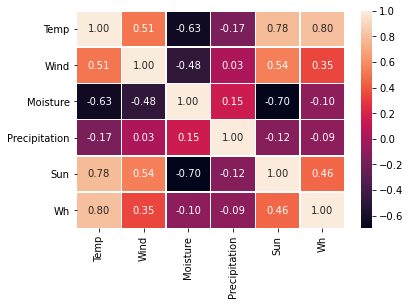

In [321]:
sns.heatmap(train_df.corr(),annot=True,fmt='.2f',linewidths=0.5)

### 각 변수-전력사용량(y값) 관계 그려보기
- 상관계수에서 나타낼 수 없는 비선형 관계 가지는지 파악

Text(0.5, 1.0, 'Sun')

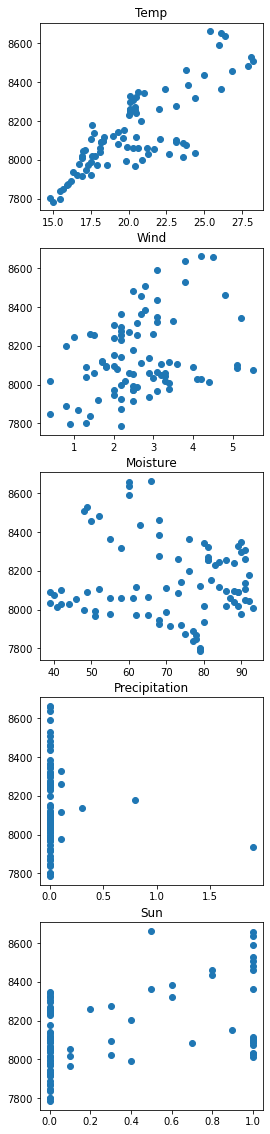

In [322]:
fig,axes=plt.subplots(nrows=5,ncols=1,figsize=(4,20))
axes[0].scatter(train_x['Temp'],train_y)
axes[1].scatter(train_x['Wind'],train_y)
axes[2].scatter(train_x['Moisture'],train_y)
axes[3].scatter(train_x['Precipitation'],train_y)
axes[4].scatter(train_x['Sun'],train_y)

axes[0].set_title('Temp')
axes[1].set_title('Wind')
axes[2].set_title('Moisture')
axes[3].set_title('Precipitation')
axes[4].set_title('Sun')

### 결론
- 분포를 보았을 때 비선형관계가 나타나는 것은 찾을 수 없었음 -> 상관계수 heatmap을 보고 변수 선정하자!
- 전력 사용량과 상관계수 절댓값 높게 나타나는 순서대로: <strong>Temp(0.80) > Sun(0.46) > Wind(0.35)</strong> > Moisture(-0.10) > Precipitation(-0.09)
- Temp-Wind 상관계수 0.51, Temp-Sun 상관계수 0.78, Wind-Sun 상관계수 0.54
- 전력사용량(y값)과 Sun, Wind 간의 상관계수가 변수들 간 상관계수보다 낮기 때문에 배제
- <strong>따라서 Temp(하나의 변수)가 전력사용량 예측에 가장 적합하다고 생각

## 전처리

위에서 선택한 변수들(feature)를 가지고 한번 전력 사용량을 예측하는 모델을 만들어 보기에 앞서,

**train 데이터의 feature의 전처리**를 진행해보려고 합니다. StandardScaler를 사용하셔도 좋고, MinMaxScaler를 사용하셔도 좋습니다! 

또한 PolynomialFeatures를 이용하거나 직접 feature를 계산하여 고차원의 feature를 만드셔도 좋습니다. 이 또한 정답은 없습니다!

이 때 최종 train_x의 shape은 (n_samples, n_features)가 되도록 해주세요.<br>
ex. 4개의 변수를 가진 1000개의 샘플의 경우 train_x.shape은 (1000,4)가 되면 됩니다.

특히 하나의 변수만을 사용하시는 분들은 1D가 아닌 2D가 되도록 신경써주세요<br>
ex. train_x.shape이 (1000,)이 아닌 (1000,1)입니다!

In [323]:
train_x['Temp'].describe()

count    88.000000
mean     20.243182
std       3.284229
min      14.800000
25%      17.600000
50%      20.100000
75%      22.175000
max      28.200000
Name: Temp, dtype: float64

<AxesSubplot:xlabel='Temp', ylabel='Count'>

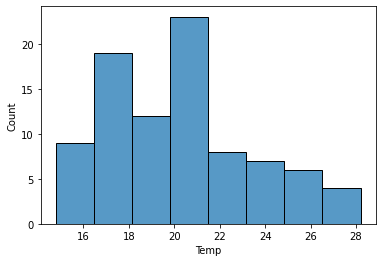

In [324]:
sns.histplot(train_x.Temp)

C:\Users\rangc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Temp'>

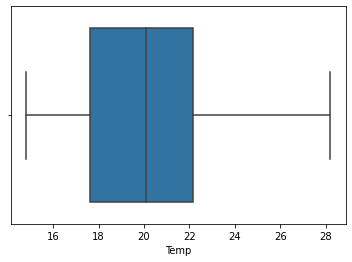

In [325]:
sns.boxplot(train_x.Temp)

In [326]:
train_x=pd.DataFrame(train_x['Temp'])

### 정규화

In [327]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler=scaler.fit(train_x)
scaled=scaler.transform(train_x)

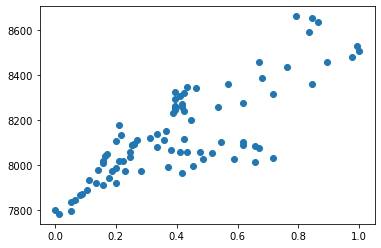

In [328]:
plt.scatter(scaled,train_y)

# 모델링

## 학습 

이제 모델링을 해봅시다.

앞서 다룬 여러 regression 모델들(Linear regression, Ridge Regression, Lasso Regression, ..)을 이용해서 fit을 진행해보도록 합시다.

In [329]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression().fit(scaled, train_y)

In [330]:
from sklearn.linear_model import Ridge
ridge_model = Ridge(random_state=123).fit(scaled, train_y)

In [331]:
from sklearn.linear_model import Lasso
lasso_model = Lasso(random_state=123).fit(scaled, train_y)

## 추정

이제 train_x를 이용하여 전력사용량을 추정해보도록 합시다.

### Linear regression

In [332]:
linear_pred_y = linear_model.predict(scaled)

linear_beta = linear_model.coef_[0]
linear_intercept = linear_model.intercept_
print(f"Beta :{linear_beta: .4f}")
print(f"Intercept : {linear_intercept: .4f}")

Beta : 667.4740
Intercept :  7871.0532


### Ridge regression

In [333]:
ridge_pred_y = ridge_model.predict(scaled)

ridge_beta = ridge_model.coef_[0]
ridge_intercept = ridge_model.intercept_
print(f"Beta :{ridge_beta:.4f}")
print(f"Intercept : {ridge_intercept: .4f}")

Beta :560.2680
Intercept :  7914.6012


### Lasso regression

In [334]:
lasso_pred_y = lasso_model.predict(scaled)

lasso_beta = lasso_model.coef_[0]
lasso_intercept = lasso_model.intercept_
print(f"Beta :{lasso_beta:.4f}")
print(f"Intercept : {lasso_intercept: .4f}")

Beta :650.6354
Intercept :  7877.8932


# Loss 및 시각화

앞서 fitting하여 얻은 모델을 이용하여 추정한 값으로 MSE를 측정해봅시다. 변수를 하나만 사용하신 분들은 xy 평면에 한번 같이 시각화도 해보셔도 좋습니다.

In [335]:
def mse(pred, true):
    return np.mean((pred-true)**2)

### Linear regression

In [336]:
linear_train_mse = mse(linear_pred_y, train_y)
print(f"Linear MSE {linear_train_mse:.5f}")

Linear MSE 14543.75828


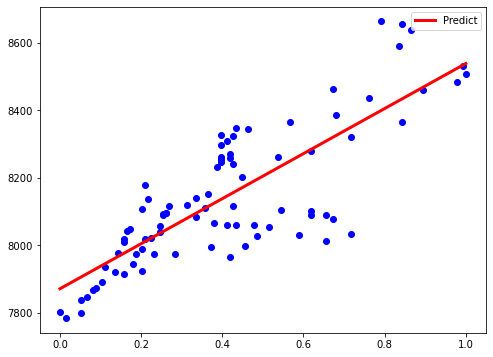

In [337]:
x_axis = np.linspace(0, 1, 100)
linear_fit = linear_beta * x_axis + linear_intercept

plt.figure(figsize=(8,6))
plt.plot(x_axis, linear_fit, label='Predict', c='r', linewidth=3)
plt.scatter(scaled, train_y, c='blue')
plt.legend()
plt.show()

### Ridge regression

In [338]:
ridge_train_mse = mse(ridge_pred_y, train_y)
print(f"Ridge MSE {ridge_train_mse:.5f}")

Ridge MSE 15226.30510


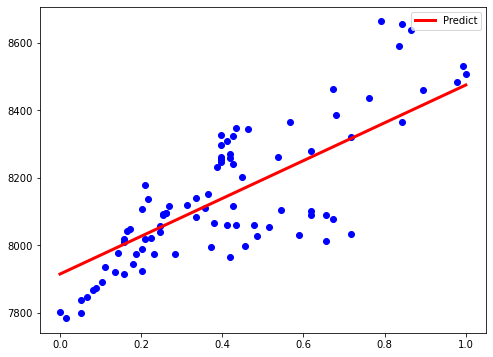

In [339]:
x_axis = np.linspace(0, 1, 100)
ridge_fit = ridge_beta * x_axis + ridge_intercept

plt.figure(figsize=(8,6))
plt.plot(x_axis, ridge_fit, label='Predict', c='r', linewidth=3)
plt.scatter(scaled, train_y, c='blue')
plt.legend()
plt.show()

### Lasso regression

In [340]:
lasso_train_mse = mse(lasso_pred_y, train_y)
print(f"Lasso MSE {lasso_train_mse:.5f}")

Lasso MSE 14560.59689


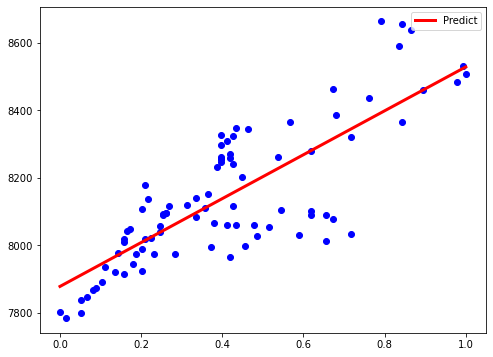

In [341]:
x_axis = np.linspace(0, 1, 100)
lasso_fit = lasso_beta * x_axis + lasso_intercept

plt.figure(figsize=(8,6))
plt.plot(x_axis, lasso_fit, label='Predict', c='r', linewidth=3)
plt.scatter(scaled, train_y, c='blue')
plt.legend()
plt.show()

### 비교

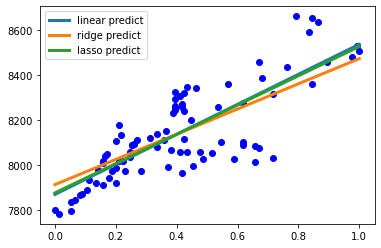

In [363]:
plt.plot(x_axis, linear_fit, label='linear predict', linewidth=3)
plt.plot(x_axis, ridge_fit, label='ridge predict', linewidth=3)
plt.plot(x_axis, lasso_fit, label='lasso predict', linewidth=3)
plt.scatter(scaled, train_y, c='blue')
plt.legend()

# 예측

테스트셋에 대해서 한번 **예측**해보도록 합시다.

이미 fitting된 모델 (그리고 scaler를 사용하신다면 scaler)에 대해 **fit을 하지 말고** 단순히 predict만 진행해보도록 합시다. 

scaler는 transform만 하시고 model은 predict을 진행해주세요

In [342]:
test_x=test_x.Temp

In [343]:
test_x=pd.DataFrame(test_x)

In [344]:
test_scaled=scaler.transform(test_x)

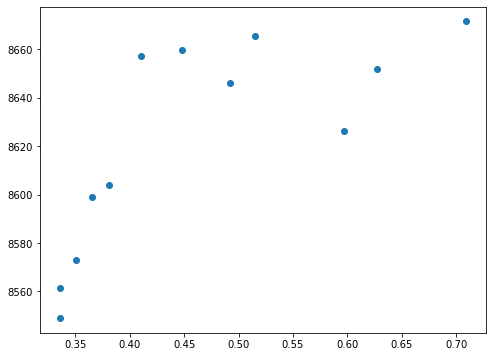

In [345]:
plt.figure(figsize=(8, 6))
plt.scatter(test_scaled, test_y)
plt.show()

In [346]:
linear_pred_y = linear_model.predict(test_scaled)
ridge_pred_y = ridge_model.predict(test_scaled)
lasso_pred_y = lasso_model.predict(test_scaled)

# 성능 평가

한번 학습한 모델에 대해 test_y를 이용하여 mse loss를 측정해도도록 합시다.

In [347]:
def score(train_mse, test_mse):
    print(f"{test_mse/train_mse: .4f}")

### Linear regression

In [348]:
linear_test_mse = mse(linear_pred_y, test_y)
print(f"Linear {linear_test_mse:.5f}")

Linear 198060.52184


In [349]:
score(linear_train_mse,linear_test_mse)

 13.6182


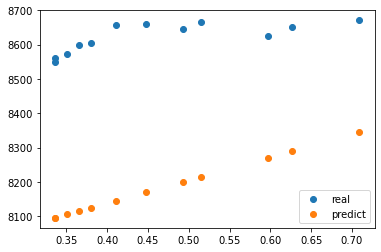

In [350]:
plt.scatter(test_scaled,test_y,label='real')
plt.scatter(test_scaled,linear_pred_y,label='predict')
plt.legend()

### Ridge regression

In [356]:
ridge_test_mse = mse(ridge_pred_y, test_y)
print(f"Ridge {ridge_test_mse:.5f}")

Ridge 202457.35936


In [357]:
score(ridge_train_mse,ridge_test_mse)

 13.2966


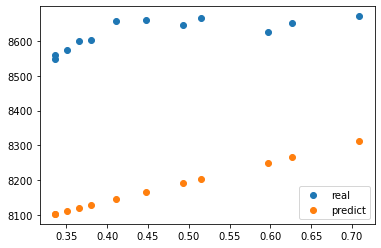

In [358]:
plt.scatter(test_scaled,test_y,label='real')
plt.scatter(test_scaled,ridge_pred_y,label='predict')
plt.legend()

### Lasso regression

In [359]:
lasso_test_mse = mse(lasso_pred_y, test_y)
print(f"Lasso {lasso_test_mse:.5f}")

Lasso 198724.10658


In [360]:
score(lasso_train_mse,ridge_test_mse)

 13.9045


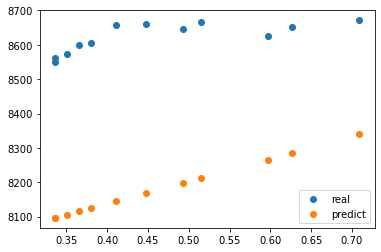

In [361]:
plt.scatter(test_scaled,test_y,label='real')
plt.scatter(test_scaled,lasso_pred_y,label='predict')
plt.legend()

### 비교

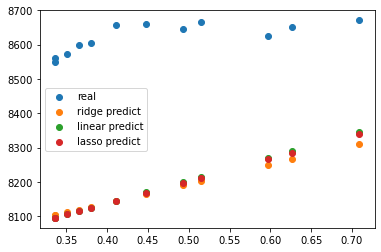

In [364]:
plt.scatter(test_scaled,test_y,label='real')
plt.scatter(test_scaled,ridge_pred_y,label='ridge predict')
plt.scatter(test_scaled,linear_pred_y,label='linear predict')
plt.scatter(test_scaled,lasso_pred_y,label='lasso predict')
plt.legend()

# 그 이후

이제 여러분들은 한번 모델을 만들어보고 fitting한 다음 예측까지 해보셨습니다.

이제 개선하기 위해 1.데이터부터 5.성능평가 중 수정, 변경하실 부분을 업데이트 해서  최적의 모델을 찾아보세요!

현재 사용하고 있는 scaler, model부터 전처리과정 기타 여러 조건을 조작해보시고 어떤 효과가 있는지 한번 보시고 알려주세요:D

- train set을 보면 기온변수와 전력사용량 사이에 어느정도 선형성이 보인다.
- 따라서 mse값을 보면 보다 유연한 모델을 만드는 ridge regression이 linear regression보다 높은 값을 갖는다.(ridge의 오차가 더 크다)
- 하지만, 추정한 모형을 통해 test set에서 예측을 해보면 세 가지 모형 모두 실제 y값과는 꽤 차이를 보인다.
- 이 이유를 모델 자체의 문제에서 찾기보다는 train set과 test set을 그려서 나타내보면 test set 자체가 train에서 보이는 경향성과는 좀 다른 모습이다.
- 데이터가 너무 적어서 train set과 test set에서 차이를 보인다고 생각한다.

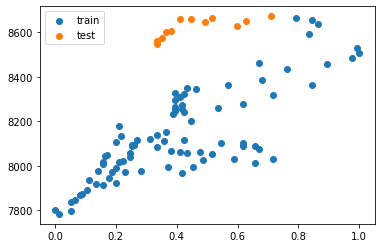

In [282]:
plt.scatter(scaled,train_y,label='train')
plt.scatter(test_scaled,test_y,label='test')
plt.legend()

고생하셨습니다!